# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов и поучаствовать в соревновании на Kaggle!
Первым делом вам предстоит построить хороший бейзлайн, а дальше пытаться улучшать, соревнуясь с другими участниками.


Ссылка на соревнование: https://www.kaggle.com/c/avito-category-prediction/overview
Данные для домашнего задания можно скачать на странице соревнования.
Чтобы ваше участие было засчитано, убедитесь, что имя в Leaderboard имеет вид: «Имя Фамилия номер_группы».

Оценивание:

Домашнее задание оценивается как обычно. Баллы указаны напротив заданий.

За соревнование даются бонусные баллы следующим образом.
Если вы пересекли baseline_2 на приватном лидерборде, ваша оценка равна 

10 - 10 * (i - 1) / M

где M — количество студентов, принявших участие в соревновании;

i — место (начиная с 1) студента в приватном лидерборде среди всех таких студентов.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* В течение 3 суток после окончания соревнования в соответствующее задание на anytask необходимо прислать код, воспроизводящий ответы для посылки, фигурирующей в приватном лидерборде. В случае отсутствия кода, воспроизводящего результат, в установленный срок студенту выставляется 0 в качестве оценки за соревнование. Если не оговорено иное, использовать любые внешние данные в соревнованиях '''запрещено'''. Под внешними данными понимаются размеченные данные, где разметка имеет прямое отношение к решаемой задаче. Грубо говоря, сборник текстов с википедии не считается внешними данными.


In [4]:
try:
    from google.colab import files, drive
    
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    import os
    print("Don't forget to avoid disconnections:")
    print("""
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    """)

Don't forget to avoid disconnections:

function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    


In [5]:
MOUNT_DIR = '/content/drive' # In case Colab Usage
if USE_COLAB:
    drive.mount(MOUNT_DIR)
    DRIVE_DIR = os.path.join(MOUNT_DIR, 'My Drive')
    print(f"Drive directory is {DRIVE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive directory is /content/drive/My Drive


In [8]:
if USE_COLAB:
    !pip install -q kaggle
    # !mkdir ~/.kaggle
    kaggle_file = os.path.join(DRIVE_DIR, 'constants/kaggle.json')
    !cp "$kaggle_file" ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle competitions download -c avito-category-prediction


 99% 835M/843M [00:07<00:00, 96.2MB/s]
100% 843M/843M [00:08<00:00, 110MB/s] 
 93% 265M/284M [00:04<00:00, 75.1MB/s]
100% 284M/284M [00:04<00:00, 66.4MB/s]
 70% 5.00M/7.17M [00:00<00:00, 24.6MB/s]
100% 7.17M/7.17M [00:00<00:00, 28.4MB/s]


In [18]:
!unzip -o  test.csv.zip -d  avito-text-classification > /dev/null
!unzip -o  train.csv.zip -d  avito-text-classification > /dev/null

Мы будем работать с датасетом объявлений Avito. Нам предстоит по заголовку и тексту объявления предсказывать категорию объявления.

In [21]:
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('avito-text-classification/train.csv', nrows=1000000)
test = pd.read_csv('avito-text-classification/test.csv')

In [3]:
len(train)

1000000

In [4]:
train = read_n_sample("avito-text-classification/train.csv", 500000)

NameError: ignored

In [5]:
len(train)

1000000

In [6]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

Для трейна:

In [7]:
 train.isna().sum()

title            0
description      0
Category_name    0
Category         0
dtype: int64

In [6]:
train.fillna("", inplace=True)

In [7]:
 train.isna().sum()

title            0
description      0
Category_name    0
Category         0
dtype: int64

Для теста:

In [8]:
test.isna().sum()

title          0
description    1
itemid         0
dtype: int64

In [9]:
test.fillna("", inplace=True)

In [10]:
test.isna().sum()

title          0
description    0
itemid         0
dtype: int64

## Задание 2 (0.5 балла)
Сконкатенируйте заголовок и описание в единую строку и поместите результат в отдельный столбец. Таким образом мы будет работать с одним текстом, а не с двумя.

In [8]:
train['text'] = train['title'] + " " + train['description']
train.drop(['title', 'description'], axis='columns', inplace=True)
train.head()

,Category_name,Category,text
0,Запчасти и аксессуары,10,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 ..."
1,Бытовая техника,21,Утюг утп 1000 ватт СССР 1987 год Продам/\n Фот...
2,Предложение услуг,114,Возвму машину с выкупом Возьму машину в аренду...
3,"Одежда, обувь, аксессуары",27,"Полусапожки полусапожки в отличном состоянии, ..."
4,"Одежда, обувь, аксессуары",27,Босоножки кожаные Кожаные(натур) босоножки Kar...


In [9]:
test['text'] = test['title'] + " " + test['description']
test.drop(['title', 'description'], axis='columns', inplace=True)
test.head()

,itemid,text
0,1778449823,Мастерка Мастерка фирмы форвард. Белого цвета....
1,1677656962,"Зимние сапоги Продаю зимние сапоги, в хорошем ..."
2,1758182804,Видеонаблюдение 8 камер В комплект Atis AMD-2M...
3,1689811299,Запчасти для GLE Запчасти GLE
4,1804706240,Бластер nerf Состояние 5+/\nПродаю потому что ...


## Задание 3 (0.5 балла)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Сколько всего уникальных классов необходимо предсказать?
2. Постройте столбчатую диаграмму распределения по классам. Нормализуйте график, чтобы видеть доли, а не абсолютные значения.
3. На сколько большой дисбаланс? Какой класс имеет самую большую долю в выборке (укажите класс и долю), какой класс наименьшую (укажите класс и долю).

Уникальных классов:

In [12]:
num = len(set(train['Category']))
num

50

Диаграмма:

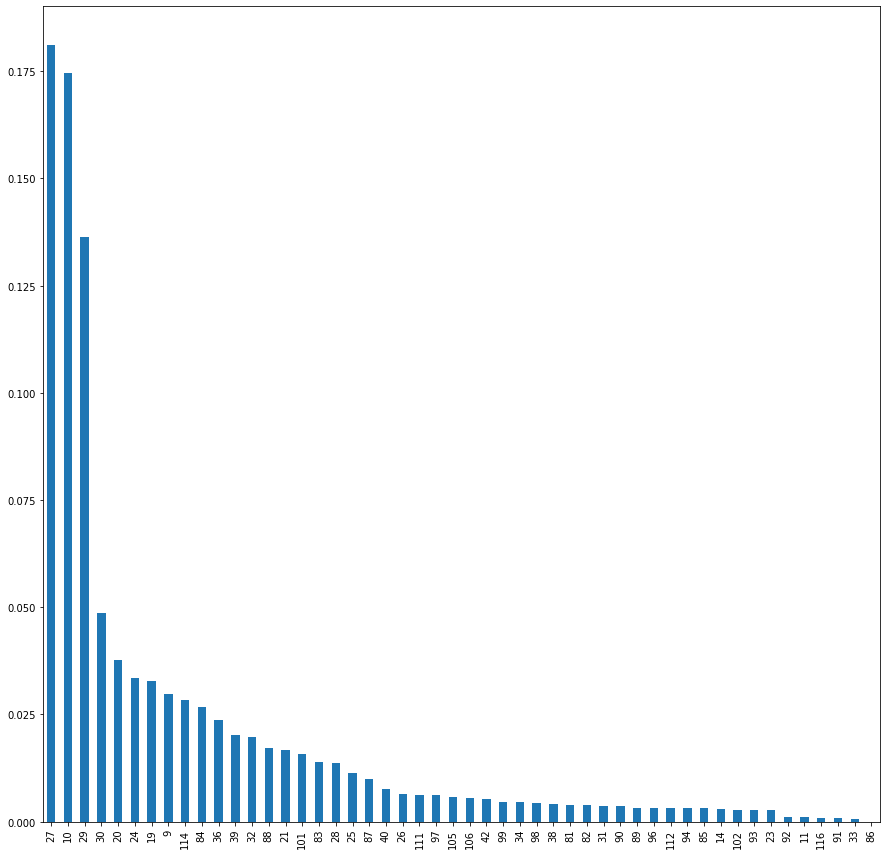

In [25]:
plt.figure(figsize = [15, 15])
train['Category'].value_counts(normalize=True).plot.bar()
plt.show()

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью. Для test части нам неизвестны истинные значения, и они понадобятся только тогда, когда мы будем отправлять решение на Kaggle.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train['text'])
X.shape

(1000000, 889197)

## Задание 5 (0.5 балла)

В предыдущем пункте у вас должная была получится очень большая матрица. Это не дело.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле _vocabulary инстанса этого класса.

1. Найдите в этом словаре все слова, которые начинаются на цифру. Сколько таких слов нашлось?

2. Найдите все слова, которые начинаются на символы пунктуации. Сколько таких слов нашлось? 

In [34]:
from_number = {k:v for k,v in vectorizer.vocabulary_.items() if k[0] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
len(from_number)

203629

In [36]:
from_punctuation = {k:v for k,v in vectorizer.vocabulary_.items() if k[0] in ['.', ',', ':', ';',  '"', '!', '?', '/']}
len(from_punctuation)

0

## Задание 6 (2.5 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью word_tokenizer из пакета nltk
2. Удалит все токены содержащие числа и пунктуацию
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords('russian')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функии на самом первом описании товара в датасете.

Важно: так как функию будет необходимо запускать на большом корпусе, подумайте об эффективной реализации. Постарайтесь решить задачу в минимальное количество циклов и копирований.

Референсная реализация на компьютере автора работала 230 секунд на 100к строчек.

In [70]:
import nltk
import re
import snowballstemmer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
def tokenizer(text):
    text = text.lower()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokenized = tokenizer.tokenize(text)
    # tokenized = nltk.word_tokenize(text)
    selected = []
    stemmer = snowballstemmer.stemmer('russian')
    nltk.download('stopwords')
    for token in tokenized:
        if (token == re.sub(r"[0-9;:.,?\-/()—]+","",token)) and (token not in stopwords.words("russian")):
            selected.append(stemmer.stemWord(token))
    return selected


In [85]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokenizer.tokenize(train['text'][0])


['Эбу',
 'Renault',
 'Nissan',
 '1',
 '5',
 'DCI',
 'Delphi',
 '2001',
 '2008',
 'год',
 'Комплект',
 'ЭБУ',
 'мозги',
 'компьютер',
 'мотора',
 'двигателя',
 'коммутатор',
 'Электронный',
 'блок',
 'управления',
 'двигателем',
 'компьютер',
 'мотора',
 'для',
 'Рено',
 'Kangoo',
 'Канго',
 'Кангу',
 'Меган',
 'Сценик',
 'Laguna',
 'Лагуна',
 'Clio',
 'Клио',
 'Nissan',
 'Micra',
 'Ниссан',
 'Микра',
 'и',
 'другие',
 'Рено',
 'Ниссан',
 '1',
 '5',
 'дизель',
 'с',
 'топливной',
 'аппаратурой',
 'Делфи',
 'Б',
 'У',
 'Оригинал',
 'отличное',
 'состояние',
 'проверенные',
 'с',
 'гарантией',
 'На',
 'все',
 'запчасти',
 'предоставляется',
 'ГАРАНТИЯ',
 'возможна',
 'установка',
 'Более',
 'подробно',
 'в',
 'разделе',
 'о',
 'компании',
 'Мы',
 'дорожим',
 'своей',
 'репутацией',
 'и',
 'торгуем',
 'ТОЛЬКО',
 'ЛЕГАЛЬНЫМИ',
 'контрактными',
 'запчастями',
 'на',
 'все',
 'детали',
 'в',
 'наличии',
 'таможенные',
 'документы',
 'Все',
 'запчасти',
 'от',
 'автомобилей',
 'БЕЗ',
 'ПРОБЕГА

In [82]:
tokenizer(train['text'][0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['эб',
 'renault',
 'nissan',
 'dci',
 'delphi',
 'год',
 'комплект',
 'эб',
 'мозг',
 'компьютер',
 'мотор',
 'двигател',
 'коммутатор',
 'электрон',
 'блок',
 'управлен',
 'двигател',
 'компьютер',
 'мотор',
 'рен',
 'kangoo',
 'канг',
 'канг',
 'мега',
 'сценик',
 'laguna',
 'лагун',
 'clio',
 'кли',
 'nissan',
 'micra',
 'нисса',
 'микр',
 'друг',
 'рен',
 'нисса',
 'дизел',
 'топливн',
 'аппаратур',
 'делф',
 'б',
 'оригина',
 'отличн',
 'состоян',
 'проверен',
 'гарант',
 'запчаст',
 'предоставля',
 'гарант',
 'возможн',
 'установк',
 'подробн',
 'раздел',
 'компан',
 'дорож',
 'сво',
 'репутац',
 'торгу',
 'легальн',
 'контрактн',
 'запчаст',
 'дета',
 'налич',
 'таможен',
 'документ',
 'запчаст',
 'автомобил',
 'пробег',
 'росс',
 'отправля',
 'друг',
 'регион',
 'таможен',
 'союз',
 'транспортн',
 'компан',
 'наложн',
 'платеж']

## Задание 7 (1 балл)

1. Возьмите случайные 500к строк из датасета. Постройте по ним CountVectorizer с применением вашего токенизатора.
2. Разбейте полученную матрицу на train, test в отношении 4 к 1. Не забудьте про target переменную.
3. Обучите SGDClassifier на полученной выборке.
4. Посчитайте метрику accuracy

## Задание 8 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество.
2. Мы можем еще сильнее уменьшите размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


## Задание 9 (1 балл)
Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 30000.
2. Какой из трех подходов показал самый высокий результат?

## Задание 10 (1.5 балла)

Пришло время выйти в мир. Отправляйтесь на Kaggle Inclass и сделайте первую посылку. Там вы найдете инструкцию как сформировать файл с предсказаниями и отправить его.